In [4]:
from global_setup import _CONN_PARAMS_DIC
from databaseLoad import read_postgres_from_queryfile

import math
import pandas
#import sqlalchemy

import geopandas as gpd
import folium
# Set Limit for displaying columns to None
pandas.set_option('max_columns', None)

In [2]:
# Path to sql query files
SQL_PATH = r"/home/eouser/Documents/code/Windatlas/windatlas/mastr/sqlCommands/"
SQL_DATA = r"loadMastrWind.sql"

SQL_DATA_PATH = SQL_PATH + SQL_DATA

dfMastrWind = read_postgres_from_queryfile(
        sql_query_path = SQL_DATA_PATH,
        db_conn_data = _CONN_PARAMS_DIC
        )

dfMastrWind['SpezifischeLeistung'] = (dfMastrWind.Nettonennleistung * 1000) / ((math.pi * dfMastrWind.Rotordurchmesser**2) / 4)
dfMastrWind["Anlagenzahl"] = 1

dfMastrWind.columns

Index(['EinheitMastrNummer', 'DatumLetzteAktualisierung',
       'LokationMaStRNummer', 'NetzbetreiberpruefungStatus',
       'NetzbetreiberpruefungDatum', 'AnlagenbetreiberMastrNummer', 'Land',
       'Bundesland', 'Landkreis', 'Gemeinde', 'Gemeindeschluessel',
       'Postleitzahl', 'Gemarkung', 'FlurFlurstuecknummern',
       'StrasseNichtGefunden', 'Hausnummer_nv', 'HausnummerNichtGefunden',
       'Ort', 'Laengengrad', 'Breitengrad', 'Registrierungsdatum',
       'Inbetriebnahmedatum', 'EinheitSystemstatus', 'EinheitBetriebsstatus',
       'NichtVorhandenInMigriertenEinheiten', 'DatumDesBetreiberwechsels',
       'DatumRegistrierungDesBetreiberwechsels', 'NameStromerzeugungseinheit',
       'Weic_nv', 'Kraftwerksnummer_nv', 'Energietraeger', 'Bruttoleistung',
       'Nettonennleistung', 'AnschlussAnHoechstOderHochSpannung',
       'FernsteuerbarkeitNb', 'FernsteuerbarkeitDv', 'FernsteuerbarkeitDr',
       'Einspeisungsart', 'GenMastrNummer', 'Lage', 'Hersteller',
       'Technolog

# Analyse Windzubau nach Jahr, Monat und Bundesland

Onshore WEA sollen nach ihrem Zubaudatum (Jahr und Monat), sowie ihrem Bundesland gruppiert werden. 

Spalten die gebraucht werden:

- Bundesland (1401.0 - 1415.0...)
- Inbetriebnahmedatum (2012-12-24 -> Jahr und Monat extrahieren zum sortieren)
- Anzahl

In [22]:
#dfMastrWind.dropna(subset=["Seelage"])
onshoreWind = dfMastrWind[dfMastrWind["Seelage"].isna()]
onshoreWind.loc[:,"InbetriebnahmeJAHR"] = onshoreWind.loc[:,"Inbetriebnahmedatum"].dt.year
onshoreWind.loc[:,"InbetriebnahmeMONAT"] = onshoreWind.loc[:,"Inbetriebnahmedatum"].dt.month
onshoreWind = onshoreWind[["Bundesland","InbetriebnahmeJAHR","InbetriebnahmeMONAT", "Anlagenzahl"]]
onshoreWindGrouped = onshoreWind.groupby(["Bundesland","InbetriebnahmeJAHR","InbetriebnahmeMONAT"]).sum()

/opt/anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<AxesSubplot:xlabel='InbetriebnahmeJAHR,InbetriebnahmeMONAT'>

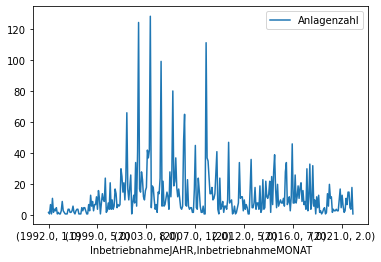

In [34]:
onshoreWindGrouped.xs((1400), level=("Bundesland")).plot(kind="line")